# The Anti-Syn Equilibrium for Nucleotides
Nucleosides and nucleotides can adopt two conformations for the glycosidic torsion ($\chi$): anti and syn. 

<img src="anti_syn.png" alt="drawing" width="400px"/>

We would like to explore which form is favored for nucleosides and estimate the free energy difference between the conformations. We will first apply a long $\sim 1\mu$s simulation and estimate the free energy. Then, we will explore the use of an enhanced sampling method (metadynamics) to estimate the free energy profile.

## Molecular Dynamics Simulations of Nucleosides
We will use molecular dynamics simulations to explore the structure of free nucleoside in water. We will see which conformation (anti or syn) is preferred. 

### The Simulation Protocol
We will perform the simulation in three steps:
- Initial minimization to remove bad initial contacts.
- Run at constant temperature and volume (NVT) to reach the desired temperature.
- Run at constant pressure and temperature (NPT) to stabilize the density.

We will use the follownig simulation parameters:
- The TIP3P and the DNA OL15 force fields.
- The particle mesh Ewald method for treating long-range interaction with periodic boundary conditions.
- 10 Angstrom cutoff distance for van der Waals interaction.
- The Langevin middle integrator with a temperature of 300 K, 1 ps$^{-1}$ friction coefficient, and 4 fs time step. We will use a technique called hydrogen mass repartitioning to allow the use of a large time step.
- The Monte Carlo barostat for controlling the pressure at 1 atm

In [11]:
# First display the adenine nucleoside
import nglview as nv
import mdtraj as md

system = md.load("A.pdb")
view = nv.show_mdtraj(system)
view.clear_representations()
view.add_representation("licorice")
view.parameters = {"cameraType": "orthographic"}
view.center()
view

NGLWidget()

In [ ]:
# NO NEED TO RUN THIS
raise Exception # protects against accidental overwriting of trajectory
from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
base = "A"
temperature = 300 # Kelvin
pdb = PDBFile(base + '.pdb')
forcefield = ForceField("amber14/DNA.OL15.xml", "amber14/tip3p.xml")
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, numAdded=350)
PDBFile.writeFile(modeller.topology, modeller.positions, open(base + "_solvated.pdb", "w"))
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds, hydrogenMass=4*amu)

integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 4*femtoseconds)
platform = Platform.getPlatformByName('CUDA')
properties = {'Precision': 'mixed'}
simulation = Simulation(modeller.topology, system, integrator, platform, properties)

simulation.context.setPositions(modeller.positions)

# Minimize the structure
simulation.minimizeEnergy()

# Perform NVT simulation
simulation.reporters.append(DCDReporter(base + '_NVT.dcd', 250)) # Store trajectory using the dcd binary format
simulation.reporters.append(StateDataReporter(base + "_NVT.txt", 250, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
simulation.step(2500)

# Add barostat
system.addForce(MonteCarloBarostat(1*atmosphere, temperature*kelvin))
state = simulation.context.getState(getPositions=True, getVelocities=True)
simulation.context.reinitialize()
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocities(state.getVelocities())

# Perform NPT simulation
simulation.reporters[0] = DCDReporter(base + '_NPT.dcd', 25000)
simulation.reporters[1] = StateDataReporter(base + "_NPT.txt", 25000, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
simulation.step(250000000)

In [9]:
# save solvent-stripped trajectory
import mdtraj as md

traj = md.load("A_NPT.dcd", top="A_solvated.pdb")
traj.top.select("resid 0")
traj.atom_slice(traj.top.select("resid 0")).save("stripped.dcd")

### Trajectory Visualization 

We will show below the trajectory without the water molecules.

In [12]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

traj = md.load("stripped.dcd", top="A.pdb")
traj = traj[200:] # Exclude 200 frames of the trajectory for equilibration
traj = traj.superpose(traj, 0, atom_indices=range(22))
view = nv.show_mdtraj(traj)
view.center(selection="not water")
view.clear_representations()
view.add_representation("licorice", selection="not water")
view.add_representation('label', labelType='serial', backgroundColor='black', showBackground=True, selection="not water")
view.parameters = {"cameraType": "orthographic"}
view

NGLWidget(max_frame=9481)

From looking at the trajectory, it looks like adenosine is mostly in the syn conformation (sugar is close to base). We can visually see why. The O5$^\prime$ and HO5$^\prime$ can form a hydrogen bond with the N3 atom of the base. However, it should be emphasized that this is hydrogen bonding interaction is irrelevant for DNA oligomers, where the O5$^\prime$ atom is used to make backbone linkages.

### Glycosidic Torsion Profile

Having confirmed visually that the syn conformatio is favored, let's determine the populations of the syn and anti conformations. We will plot a histogram of $\chi$ values observed in the simulations.

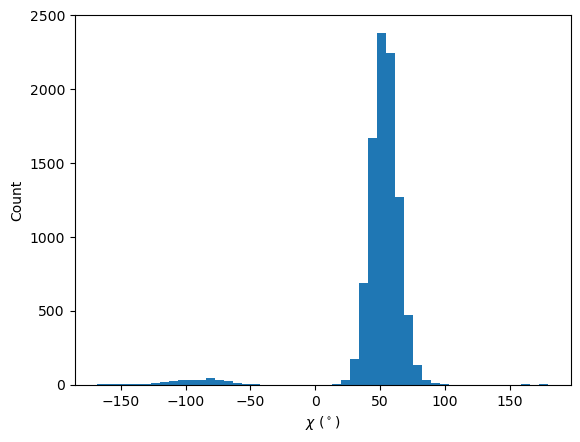

In [9]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

traj = md.load("stripped.dcd", top="A.pdb")
traj = traj[250:] # Exclude 250 frames of the trajectory for equilibration
chi = md.compute_dihedrals(traj, [[7, 8, 10, 23]])*180/np.pi # adenine
chi = np.squeeze(chi)
plt.figure()
plt.hist(chi, bins=50)
plt.xlabel("$\chi$ $(^\circ)$")
plt.ylabel("Count")
plt.show()

The histogram indeed confirms the existence of two minimum structures (anti and syn). It also confirms that the syn conformation is dominant. Now let's how $\chi$ changes with time.

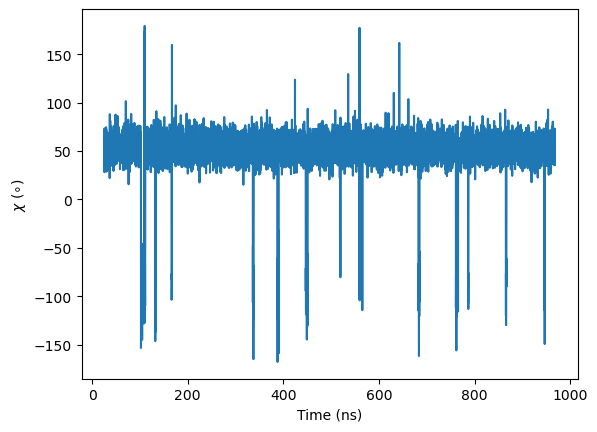

In [15]:
time = np.loadtxt(base + "_NPT.txt", delimiter=",", usecols=(0,), skiprows=250)/1000
plt.plot(time, chi)
plt.xlabel("Time (ns)")
plt.ylabel("$\chi$ ($\circ$)")
plt.show()

Clearly, the adenosine nucleoside remains most of the time in the syn conformation, but it jumps back and forth to the anti conformation. It should be emphasized that intermediate values of $\chi$ are not observed simply because they are transient configurations and because we did not save snapshots in more frequent intervals. We used a relatively large time interval (100 ps) for saving snapshots to reduce storage requirements and enable a longer simulation.

### Estimating Free Energy Difference
We can estimate the free energy profile (also called potential of mean force, or PMF) along the $\chi$ degree of freedom using the following formula: $\textrm{PMF}(i) = -RT \textrm{ln}(n_i/n_{\rm max})$, where $\chi$ is discretized to 3$^\circ$ bins, $n_i$ is the count of the $i$th bin, and $n_{\rm max}$ is the count of the most populated bin.

/tmp/ipykernel_7288/4173480876.py:4: RuntimeWarning: divide by zero encountered in log
  pmf = -8.314*300*np.log(counts/np.max(counts))/1000


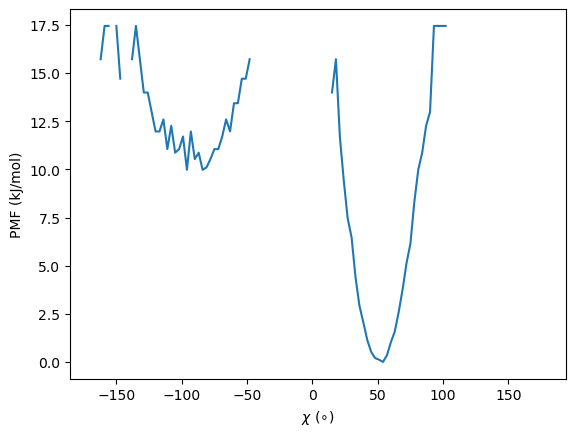

In [17]:
hist = np.histogram(chi, bins=120, range=(-180, 180))
bins = hist[1][:-1]
counts = hist[0]
pmf = -8.314*300*np.log(counts/np.max(counts))/1000

plt.plot(bins, pmf)
plt.xlabel("$\chi$ ($\circ$)")
plt.ylabel("PMF (kJ/mol)")
plt.show()

We can see from the profile that the syn conformation is favored by approximately 10 kJ/mol. This regular (unbiased) molecular dynamics simulation thus allowed us to estimate the free energy difference.

One limitation of the above approach is that relatively long simulation is required to ensure the collection of enough statistics and the convergence of the free energy values. It should be emphasized again that molecular dynamics simulation is a statistical approach. No single snapshot is meaningful, and the simulations should be long enough and reproducible to obtain reliable thermodynamic data. If we ran a short (e.g., 50 ns) simulation, we would not have observed the transition to the anti conformation. A second limitation is that the energy barrier to the conversion was not estimated because the high energy region has not been sampled sufficiently. 

## Metadynamics
We can address the above limitation using metadynamics, which introduces a biasing force that allows the system to effectively explore the free energy surface. The metadynamics simulation will be substantially shorter and will give us access to the complete free energy profile.

In [1]:
# METADYNAMICS
import numpy as np
from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
base = "A"
temperature = 300 # Kelvin
pdb = PDBFile(base + '.pdb')
forcefield = ForceField("amber14/DNA.OL15.xml", "amber14/tip3p.xml")
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, numAdded=350)
PDBFile.writeFile(modeller.topology, modeller.positions, open(base + "_solvated.pdb", "w"))
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds, hydrogenMass=4*amu)

cv = CustomTorsionForce('theta')
cv.addTorsion(7, 8, 10, 23)
chi = BiasVariable(cv, -np.pi, np.pi, biasWidth=0.35, periodic=True, gridWidth=100)
meta = Metadynamics(system, [chi], temperature=300.0, biasFactor=10.0, height=1, frequency=500, saveFrequency=500, biasDir='./')

integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 4*femtoseconds)
platform = Platform.getPlatformByName('CUDA')
properties = {'Precision': 'mixed'}
simulation = Simulation(modeller.topology, system, integrator, platform, properties)

simulation.context.setPositions(modeller.positions)

# Minimize the structure
simulation.minimizeEnergy()

# Perform NVT simulation
simulation.reporters.append(DCDReporter(base + '_NVT_meta.dcd', 500)) # Store trajectory using the dcd binary format
simulation.reporters.append(StateDataReporter(base + "_NVT_meta.txt", 500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
simulation.step(5000)

# Add barostat
system.addForce(MonteCarloBarostat(1*atmosphere, temperature*kelvin))
state = simulation.context.getState(getPositions=True, getVelocities=True)
simulation.context.reinitialize()
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocities(state.getVelocities())

# Perform NPT simulation
simulation.reporters[0] = DCDReporter(base + '_NPT_meta.dcd', 5000)
simulation.reporters[1] = StateDataReporter(base + "_NPT_meta.txt", 5000, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
simulation.step(5000)

meta.step(simulation,1000000)

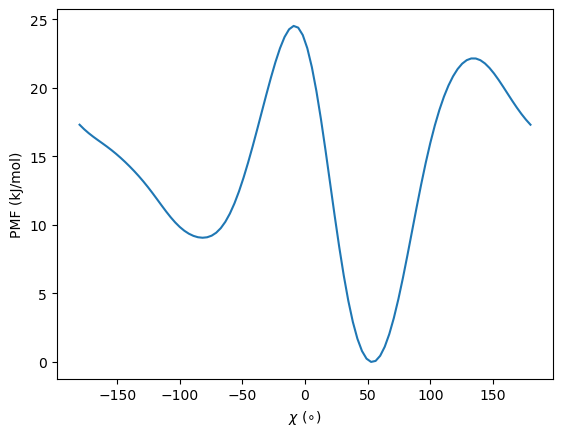

In [3]:
import matplotlib.pyplot as plt
angles = np.linspace(-np.pi, np.pi, meta.getFreeEnergy().shape[0])*180/np.pi
free_energy = meta.getFreeEnergy() - np.min(meta.getFreeEnergy())
plt.plot(angles, free_energy)
plt.xlabel("$\chi$ ($\circ$)")
plt.ylabel("PMF (kJ/mol)")
plt.show()

We can see that the result from the unbiased molecular dynamics simulations and the metadynamics simulation are consistent. The free energy difference between the two states is again 10 kJ/mol. Furthermore, the barrier between the anti and syn conformations have been determined.